In [1]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import chex
import optax
from tqdm.autonotebook import tqdm
from functools import partial

from flow.distribution import make_equivariant_augmented_flow_dist
from target import double_well as dw
from utils.loggers import ListLogger

/tmp/ipykernel_16598/2825945601.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [4]:
from utils.plotting import plot_history
import matplotlib.pyplot as plt

In [5]:
def load_dataset(batch_size, train_test_split_ratio: float = 0.8, seed = 0,
                 independant: bool = True):
    """Load dataset and add augmented dataset N(0, 1). """
    # Make length divisible by batch size also.

    dataset = np.load('target/data/dw_data_vertices4_dim2.npy')

    if independant:
        augmented_dataset = jnp.mean(dataset, axis=(1, 2), keepdims=True) + \
                            jax.random.normal(jax.random.PRNGKey(seed), shape=dataset.shape)
    else:
        # p(a, x) = p(x)p(a | x)
        augmented_dataset = dataset + jax.random.normal(jax.random.PRNGKey(seed), shape=dataset.shape)
    dataset = jnp.concatenate((dataset, augmented_dataset), axis=-1)


    train_index = int(dataset.shape[0] * train_test_split_ratio)
    train_set = dataset[:train_index]
    test_set = dataset[train_index:]

    train_set = train_set[:-(train_set.shape[0] % batch_size)]
    test_set = test_set[:-(test_set.shape[0] % batch_size)]
    return train_set, test_set


@partial(jax.jit, static_argnums=(2,))
def eval(params, x, log_prob_fn,):
    log_prob = log_prob_fn.apply(params, x)
    info = {"eval_log_lik": jnp.mean(log_prob),
            "eval_kl": jnp.mean(dw.log_prob_fn(x) - log_prob)}
    return info


def loss_fn(params, x, log_prob_fn):
    log_prob = log_prob_fn.apply(params, x)
    loss = - jnp.mean(log_prob)
    info = {"loss": loss}
    return loss, info



@partial(jax.jit, static_argnums=(3, 4))
def step(params, x, opt_state, log_prob_fn, optimizer):
    grad, info = jax.grad(loss_fn, has_aux=True)(params, x, log_prob_fn)
    updates, new_opt_state = optimizer.update(grad, opt_state, params=params)
    new_params = optax.apply_updates(params, updates)
    info.update(grad_norm=optax.global_norm(grad))
    return new_params, new_opt_state, info


def plot_sample_hist(samples, ax, dim=(0, 1), vertices=(0, 1), *args, **kwargs):
    d = jnp.linalg.norm(samples[:, vertices[0], dim] - samples[:, vertices[1], dim], axis=-1)
    ax.hist(d, bins=50, density=True, alpha=0.4, *args, **kwargs)

In [6]:
n_epoch = int(1e3)
max_global_norm = 100.0 # jnp.inf
dim = 2
lr = 2e-4
n_nodes = 4
n_layers = 6
batch_size = 256
mlp_units = (256, 256)
key = jax.random.PRNGKey(0)
flow_type = "nice"  # "nice", "proj", "vector_scale_shift"
identity_init = True # False if flow_type == "vector_scale_shift" else True
independant_target = True

n_plots = 5 # number of times to plot during training

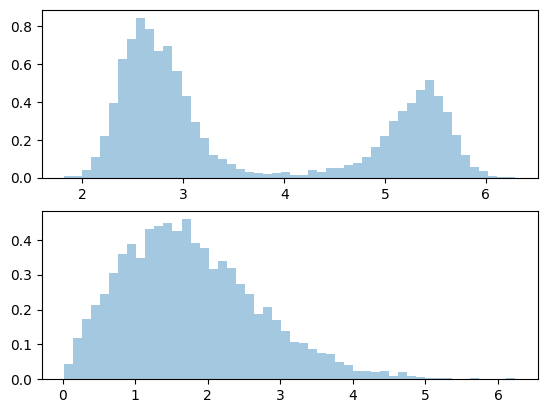

In [7]:
train_data, test_data = load_dataset(batch_size, independant=independant_target)

# Plot target.
fig, axs = plt.subplots(2)
plot_sample_hist(train_data, axs[0], dim=(0,1))
plot_sample_hist(train_data, axs[1], dim=(2,3))

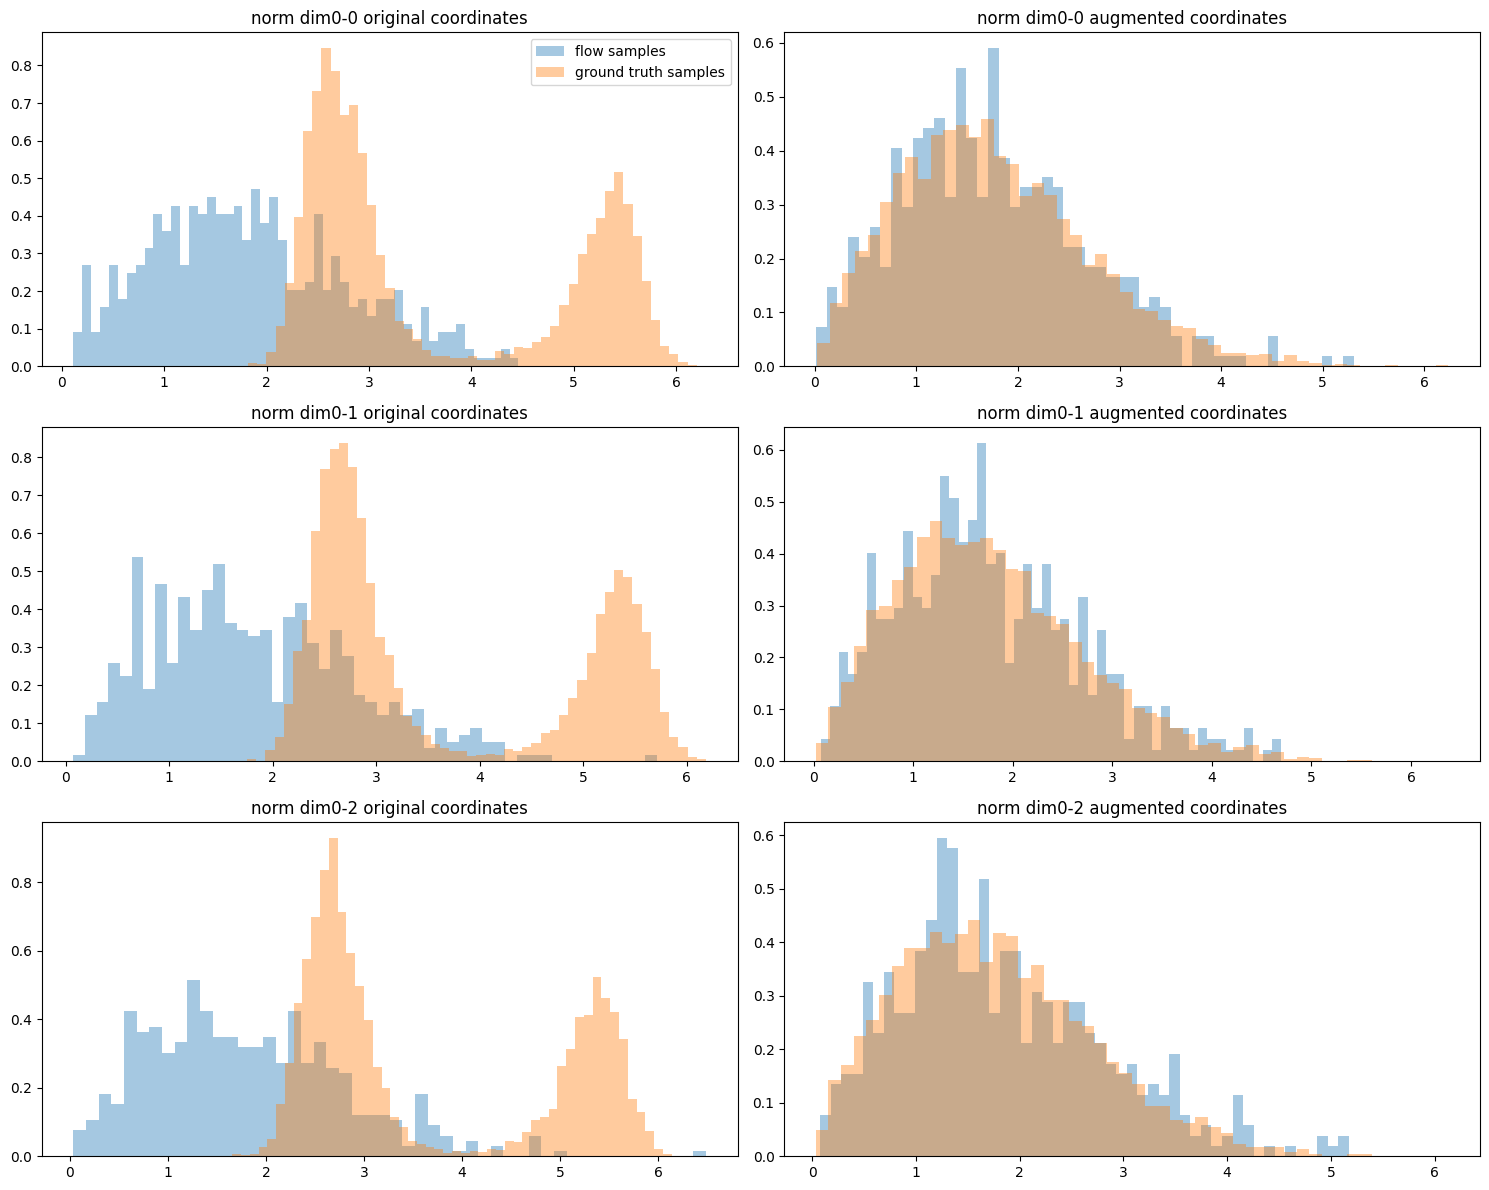

In [8]:
logger = ListLogger()


@hk.without_apply_rng
@hk.transform
def log_prob_fn(x):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.log_prob(x)

@hk.transform
def sample_and_log_prob_fn(sample_shape=()):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.sample_and_log_prob(seed=hk.next_rng_key(), sample_shape=sample_shape)

key, subkey = jax.random.split(key)
params = log_prob_fn.init(rng=subkey, x=jnp.zeros((1, n_nodes, dim*2)))

optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(max_global_norm), optax.adam(lr))
opt_state = optimizer.init(params)


def plot(n_samples=512):
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    samples = \
    jax.jit(sample_and_log_prob_fn.apply, static_argnums=(2,))(params, jax.random.PRNGKey(0), (n_samples,))[0]

    for i in range(3):
        plot_sample_hist(samples, axs[i, 0], dim=(0, 1), vertices=(0, i+1), label="flow samples")
        plot_sample_hist(train_data, axs[i, 0], dim=(0, 1), vertices=(0, i+1), label="ground truth samples")
        plot_sample_hist(samples, axs[i, 1], dim=(2, 3), vertices=(0, i+1), label="flow samples")
        plot_sample_hist(train_data, axs[i, 1], dim=(2, 3), vertices=(0, i+1),
                         label="ground truth samples")
        axs[i, 0].set_title(f"norm dim0-{i+1} original coordinates")
        axs[i, 1].set_title(f"norm dim0-{i+1} augmented coordinates")
    axs[0, 0].legend()
    plt.tight_layout()
    plt.show()
    

plot()

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

non numeric history values being saved


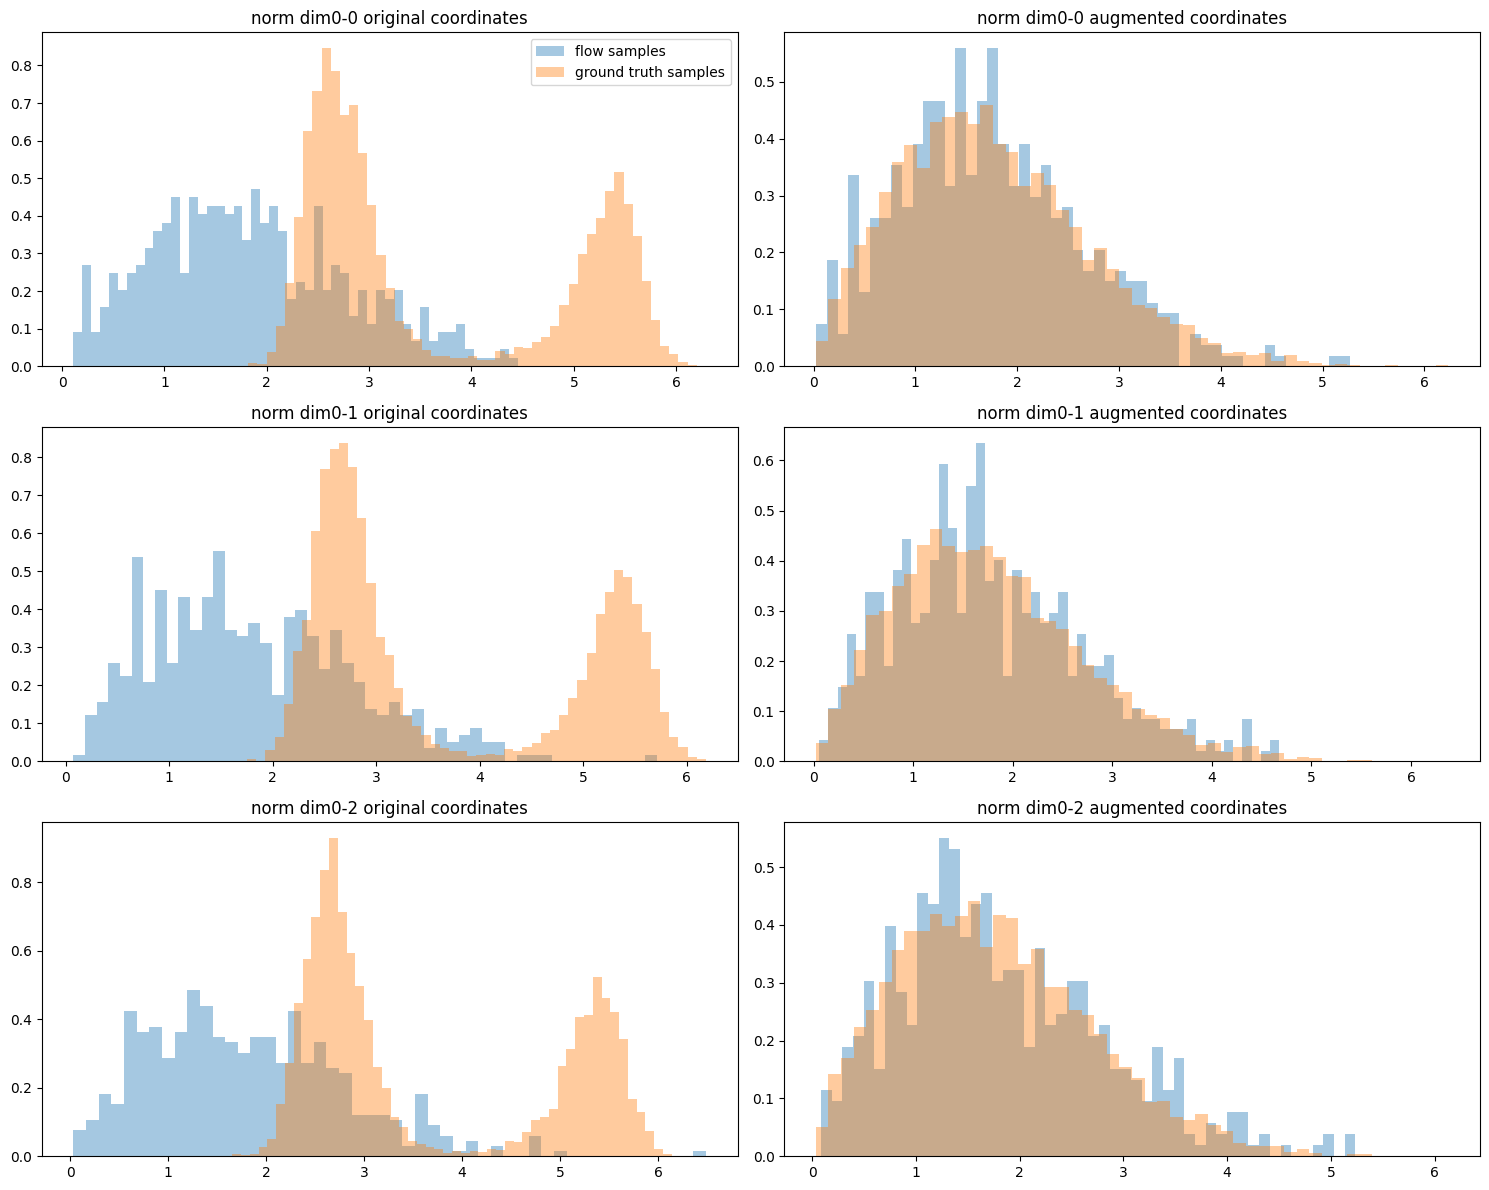

 20%|████████████████████████████████▍                                                                                                                                  | 199/1000 [00:25<01:04, 12.37it/s]

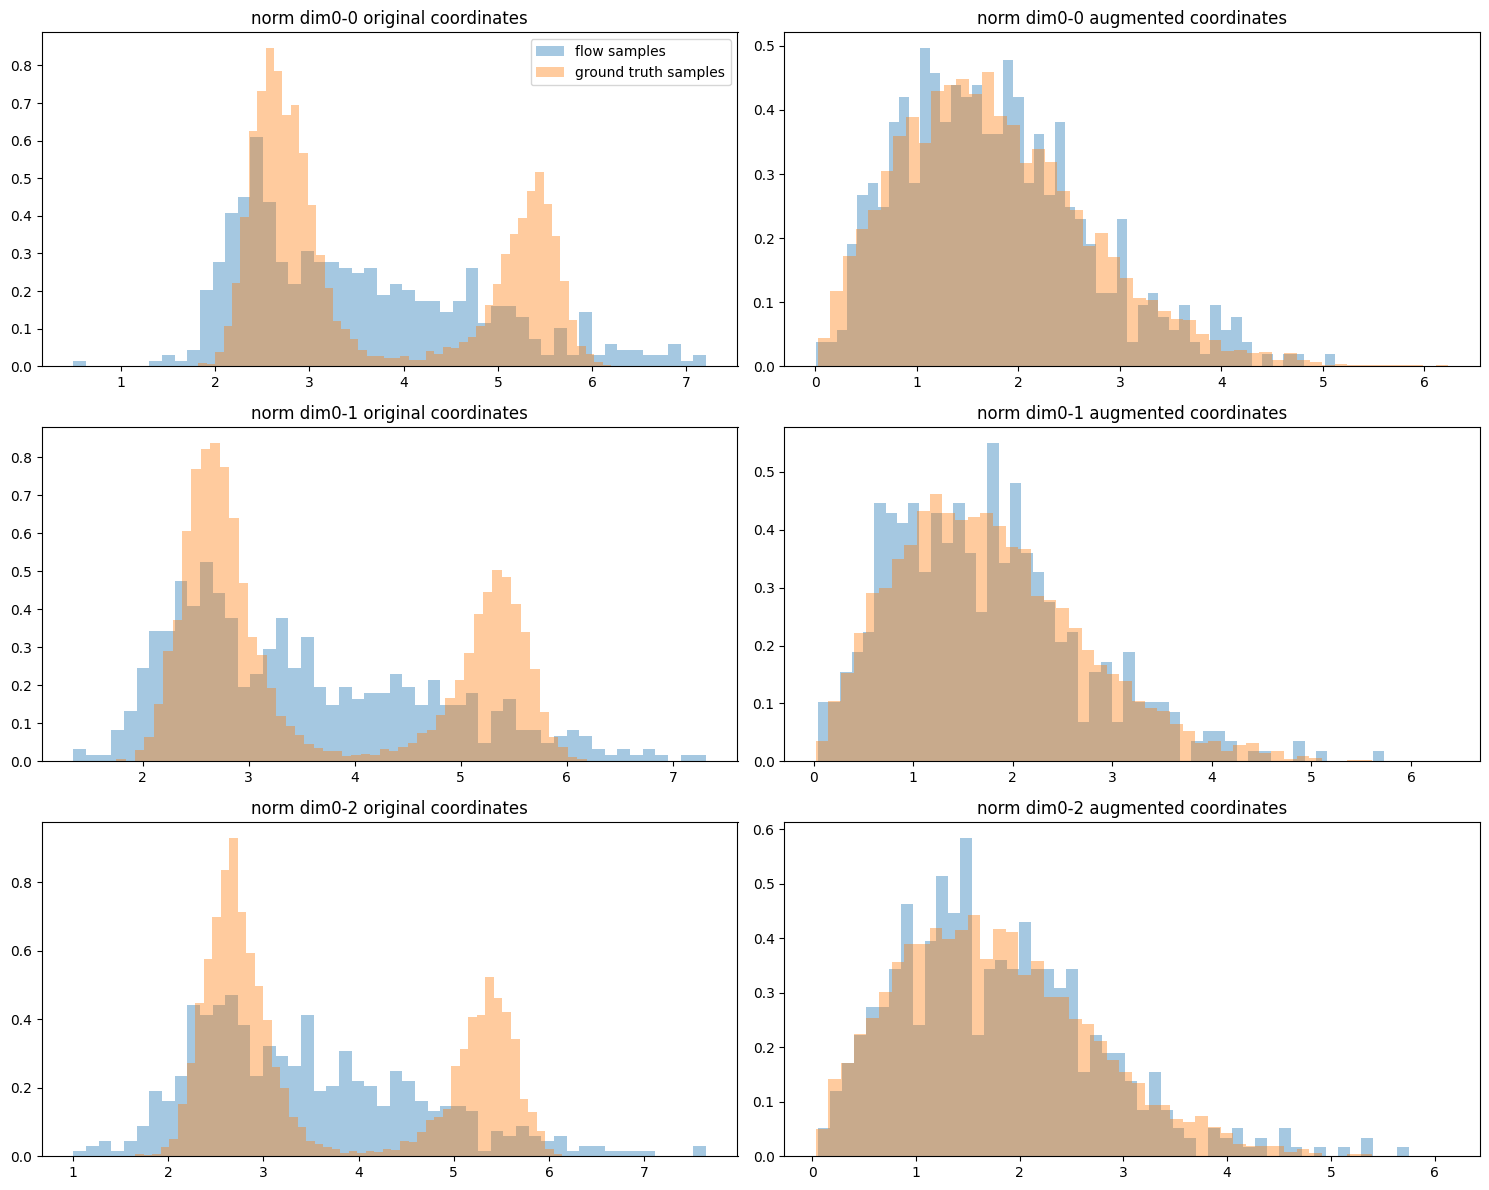

 40%|█████████████████████████████████████████████████████████████████                                                                                                  | 399/1000 [00:44<00:48, 12.33it/s]

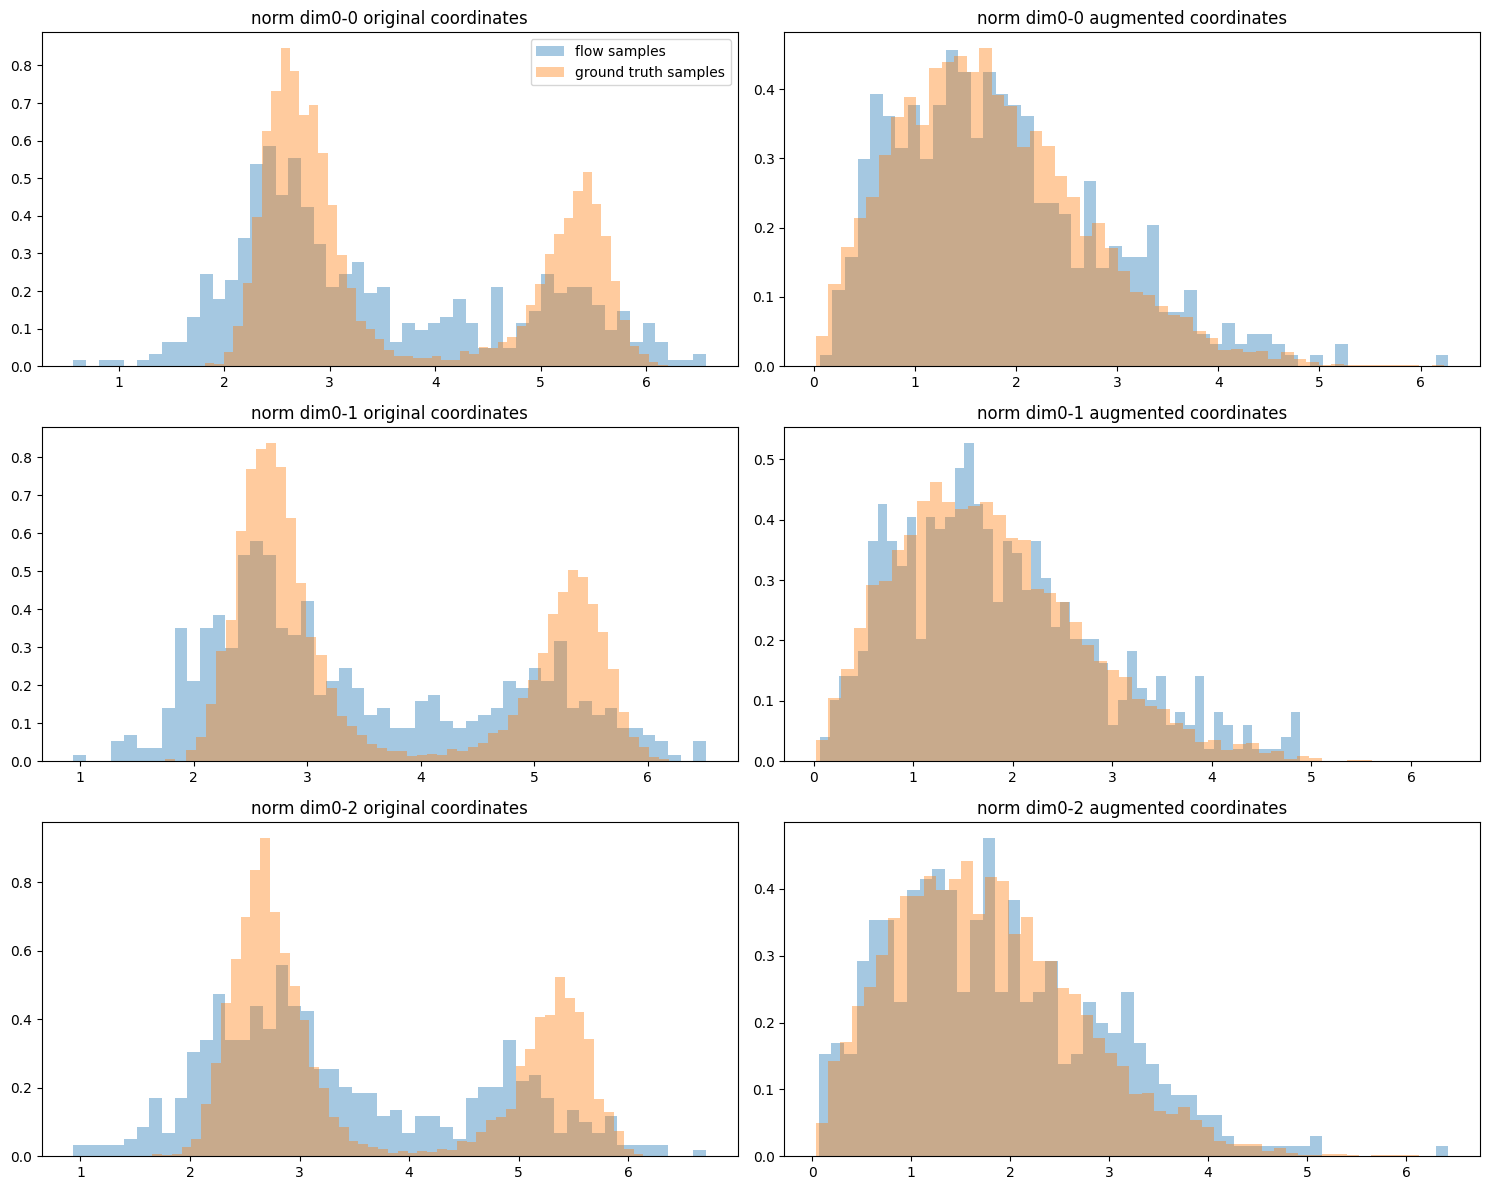

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 600/1000 [01:03<00:32, 12.17it/s]

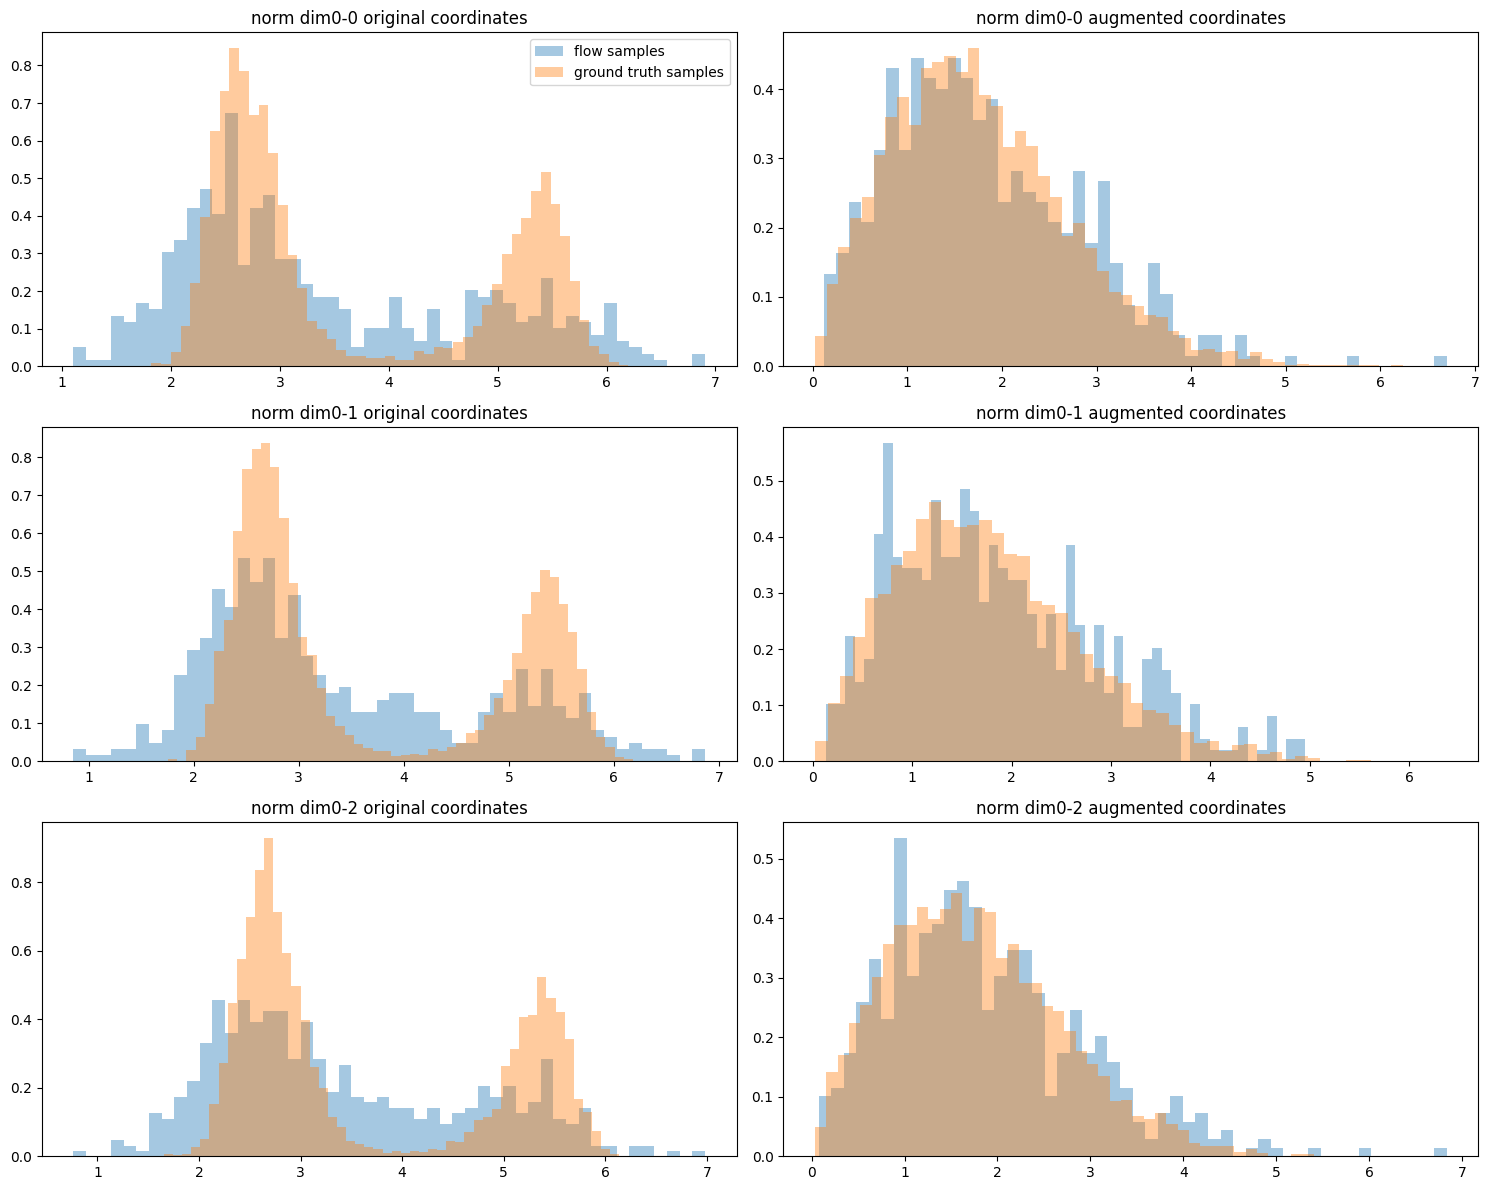

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 800/1000 [01:22<00:16, 12.26it/s]

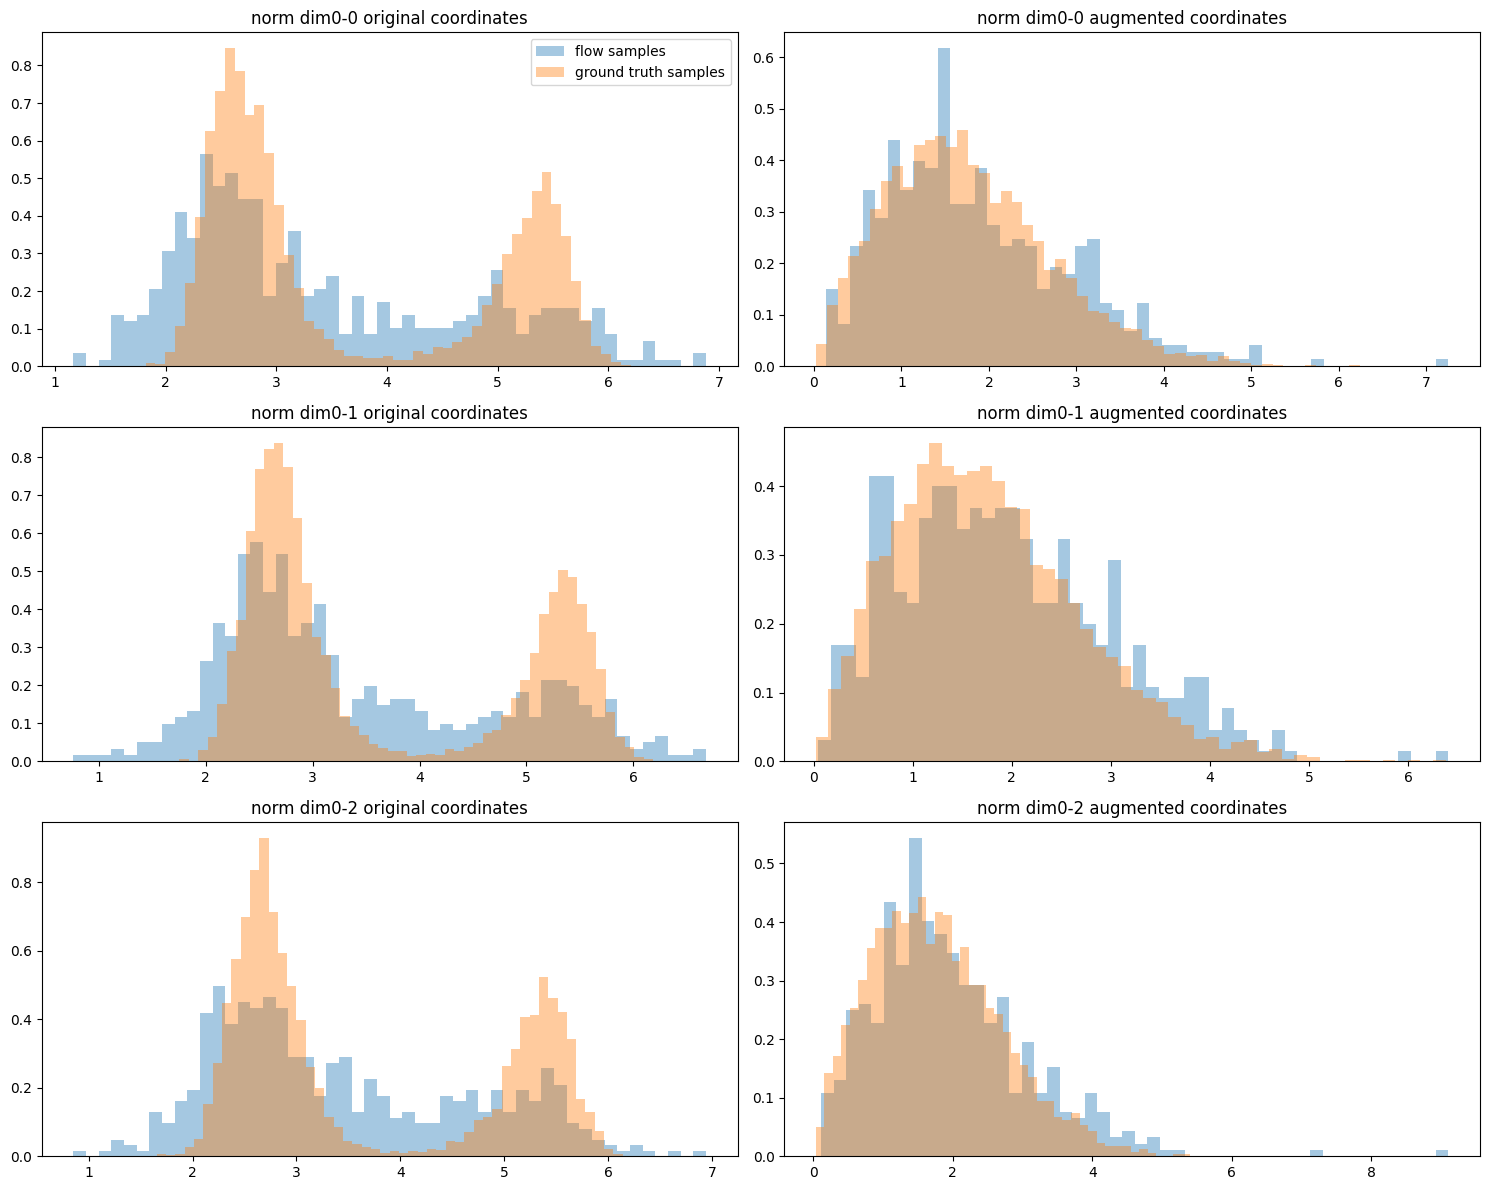

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92it/s]


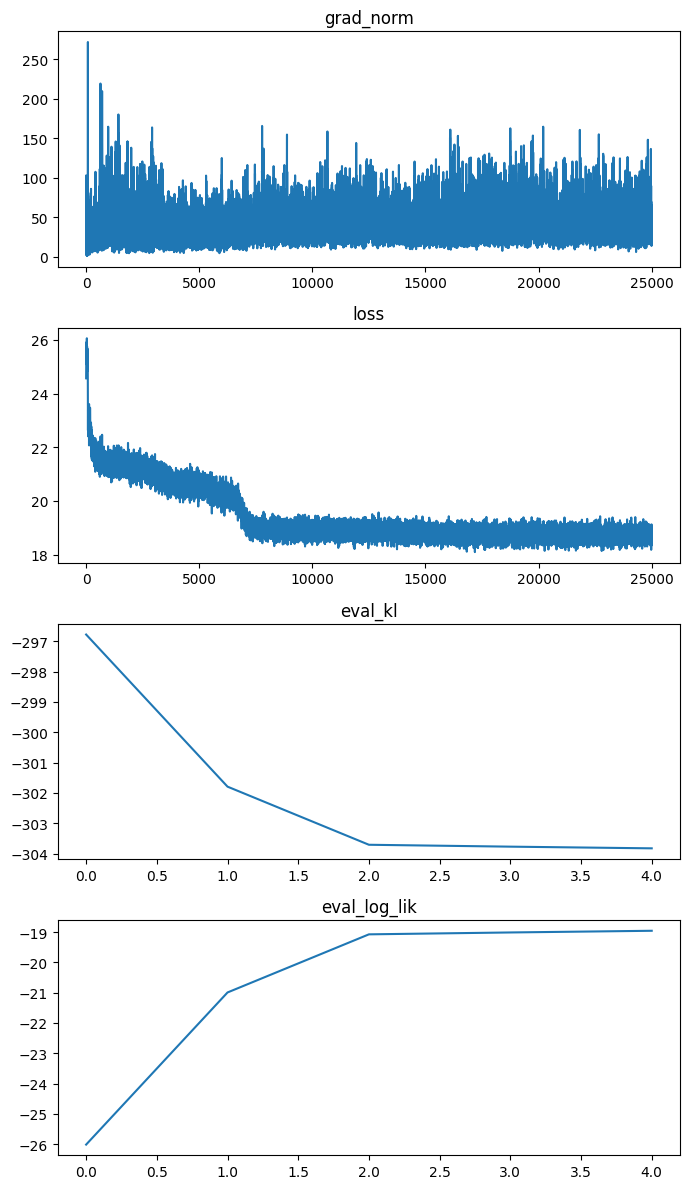

In [9]:
pbar = tqdm(range(n_epoch))
for i in pbar:
    for x in jnp.reshape(train_data, (-1, batch_size, *train_data.shape[1:])):
        params, opt_state, info = step(params, x, opt_state, log_prob_fn, optimizer)
        logger.write(info)
        if jnp.isnan(info["grad_norm"]):
            print("nan grad")
            raise Exception("nan grad encountered")

    key, subkey = jax.random.split(key)
    train_data = jax.random.permutation(subkey, train_data, axis=0)
    if i % (n_epoch // n_plots) == 0:
        plot()
        eval_info = eval(params, test_data, log_prob_fn)
        logger.write(eval_info)


plot_history(logger.history)
plt.show()

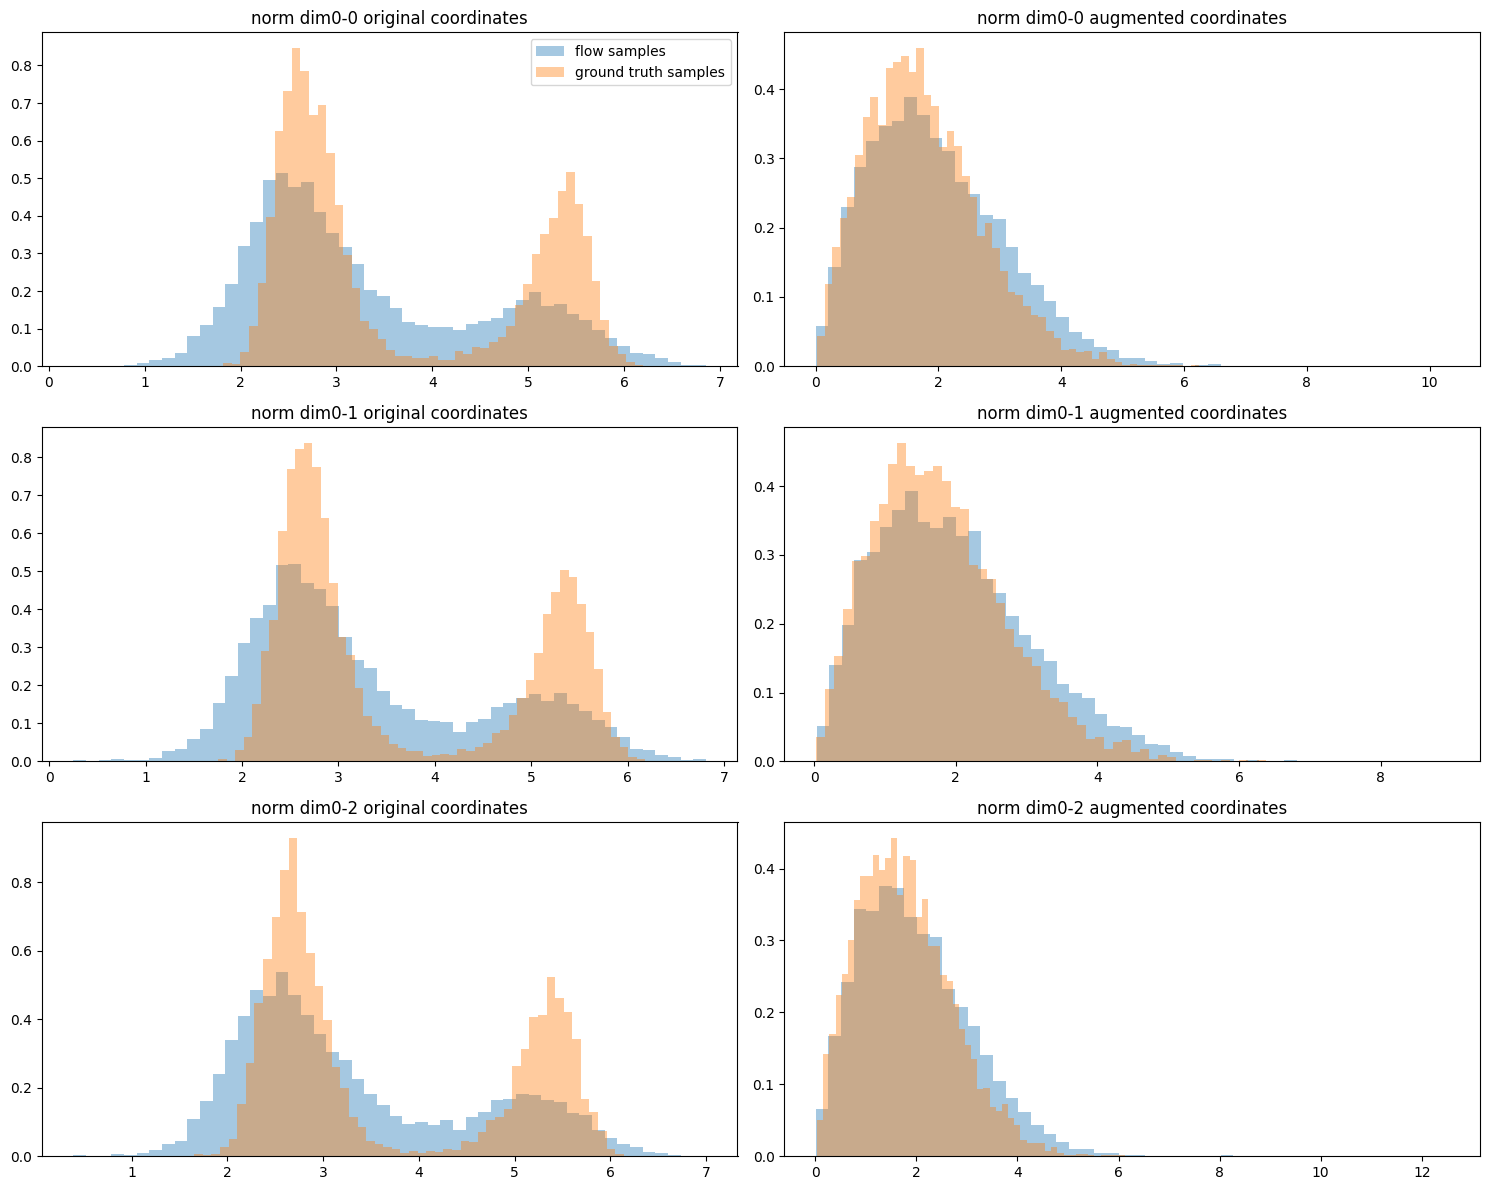

In [10]:
plot(10000)

# Tests
Test the distribution and bijector

In [11]:
from flow.test_utils import test_fn_is_invariant, test_fn_is_equivariant, rotate_translate_2d

key, subkey = jax.random.split(key)
test_fn_is_invariant(lambda x: log_prob_fn.apply(params, x), subkey, n_nodes=n_nodes)

# Check that if we rotated and translate the test set, that the log prob is the same. 

key1, key2 = jax.random.split(key)
theta = jax.random.uniform(key1) * 2*jnp.pi
translation = jax.random.normal(key2, shape=(dim,))
rotated_test_data = jax.vmap(rotate_translate_2d, in_axes=(0, None, None))(test_data, theta, translation)

log_probs_test = log_prob_fn.apply(params, test_data )
log_probs_rot_test = log_prob_fn.apply(params, rotated_test_data )

# If 64 bit then very small, if 32 bit then still small but less small. 
print(jnp.sum(jnp.abs(log_probs_test - log_probs_rot_test)))

0.0032281876


In [12]:
rotated_test_data[0], test_data[0]

(Array([[-0.64214027,  3.2623513 , -1.241831  ,  0.9157463 ],
        [ 2.1594925 , -1.1611056 , -1.9072326 , -0.5847521 ],
        [-3.3186073 , -1.1345468 , -1.6315811 ,  0.9485038 ],
        [-0.70110196, -1.7953674 , -1.125697  , -1.9742824 ]],      dtype=float32),
 Array([[-2.9391267, -1.687369 , -0.7006732, -0.762432 ],
        [-1.0741825,  3.2052886,  0.899503 , -0.3967946],
        [ 2.1849933, -1.1978989, -0.4935142, -1.0941899],
        [ 1.1467905,  1.2941192,  1.5443392,  1.0612104]], dtype=float32))

# Alternative Flow type

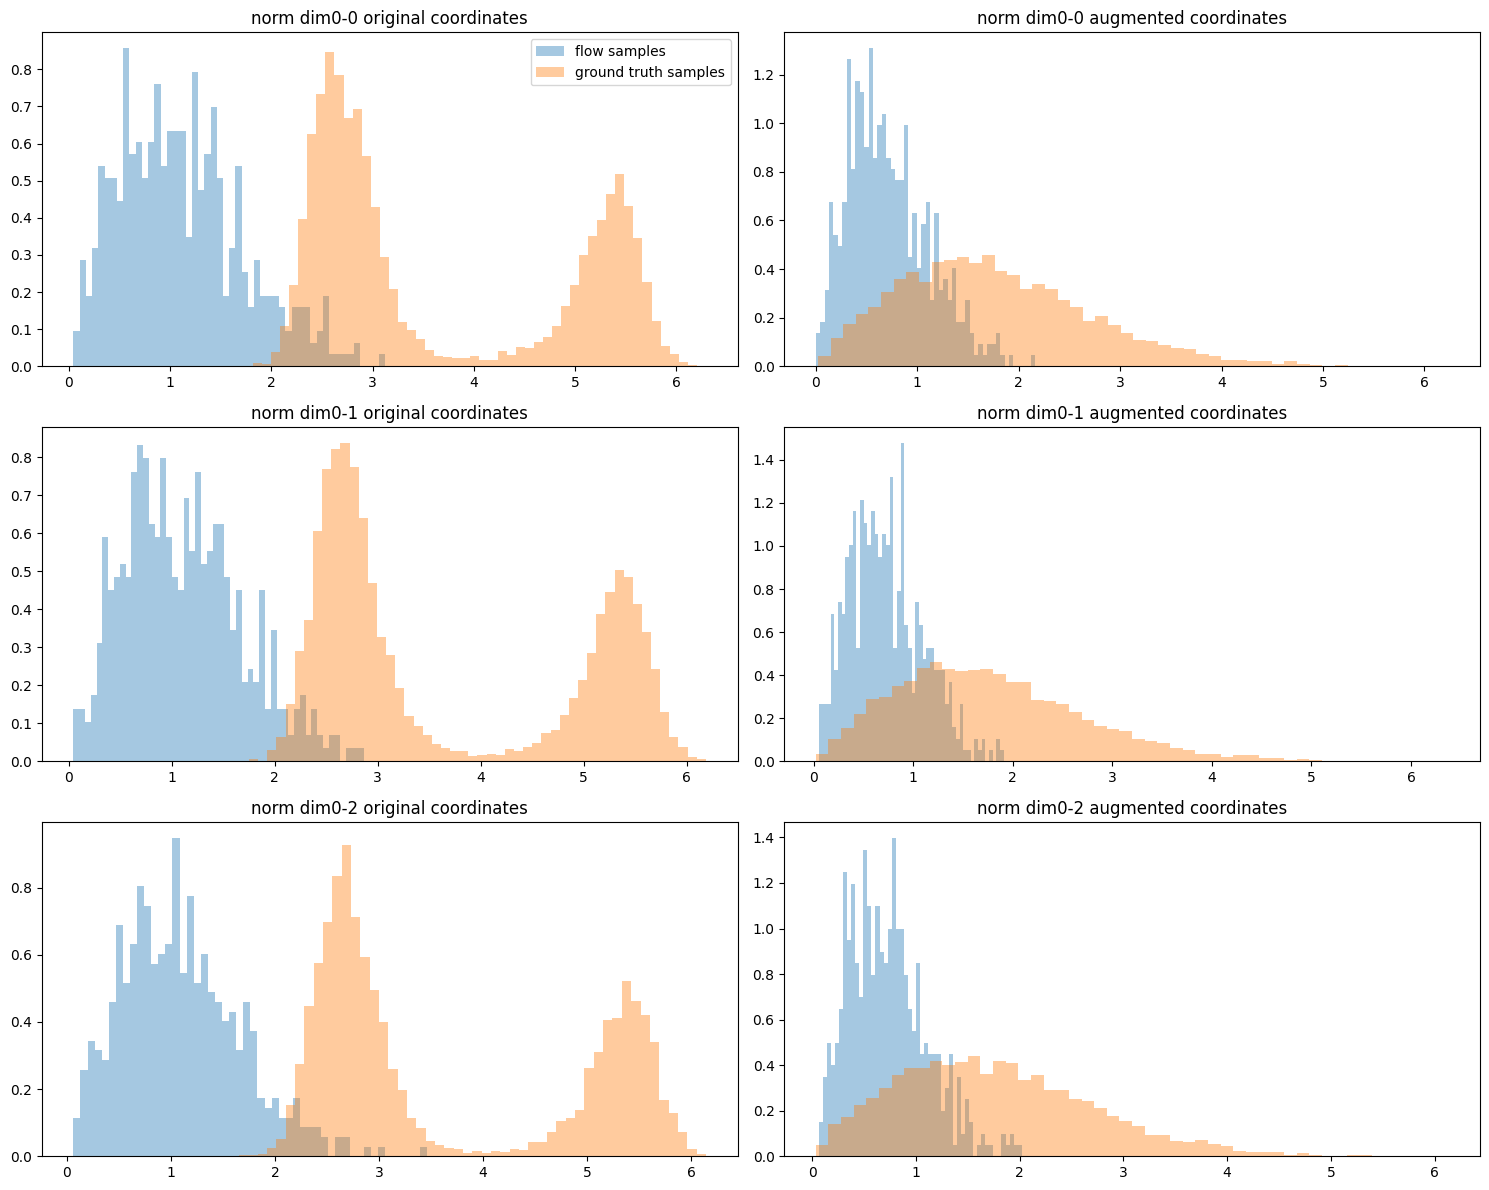

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

non numeric history values being saved


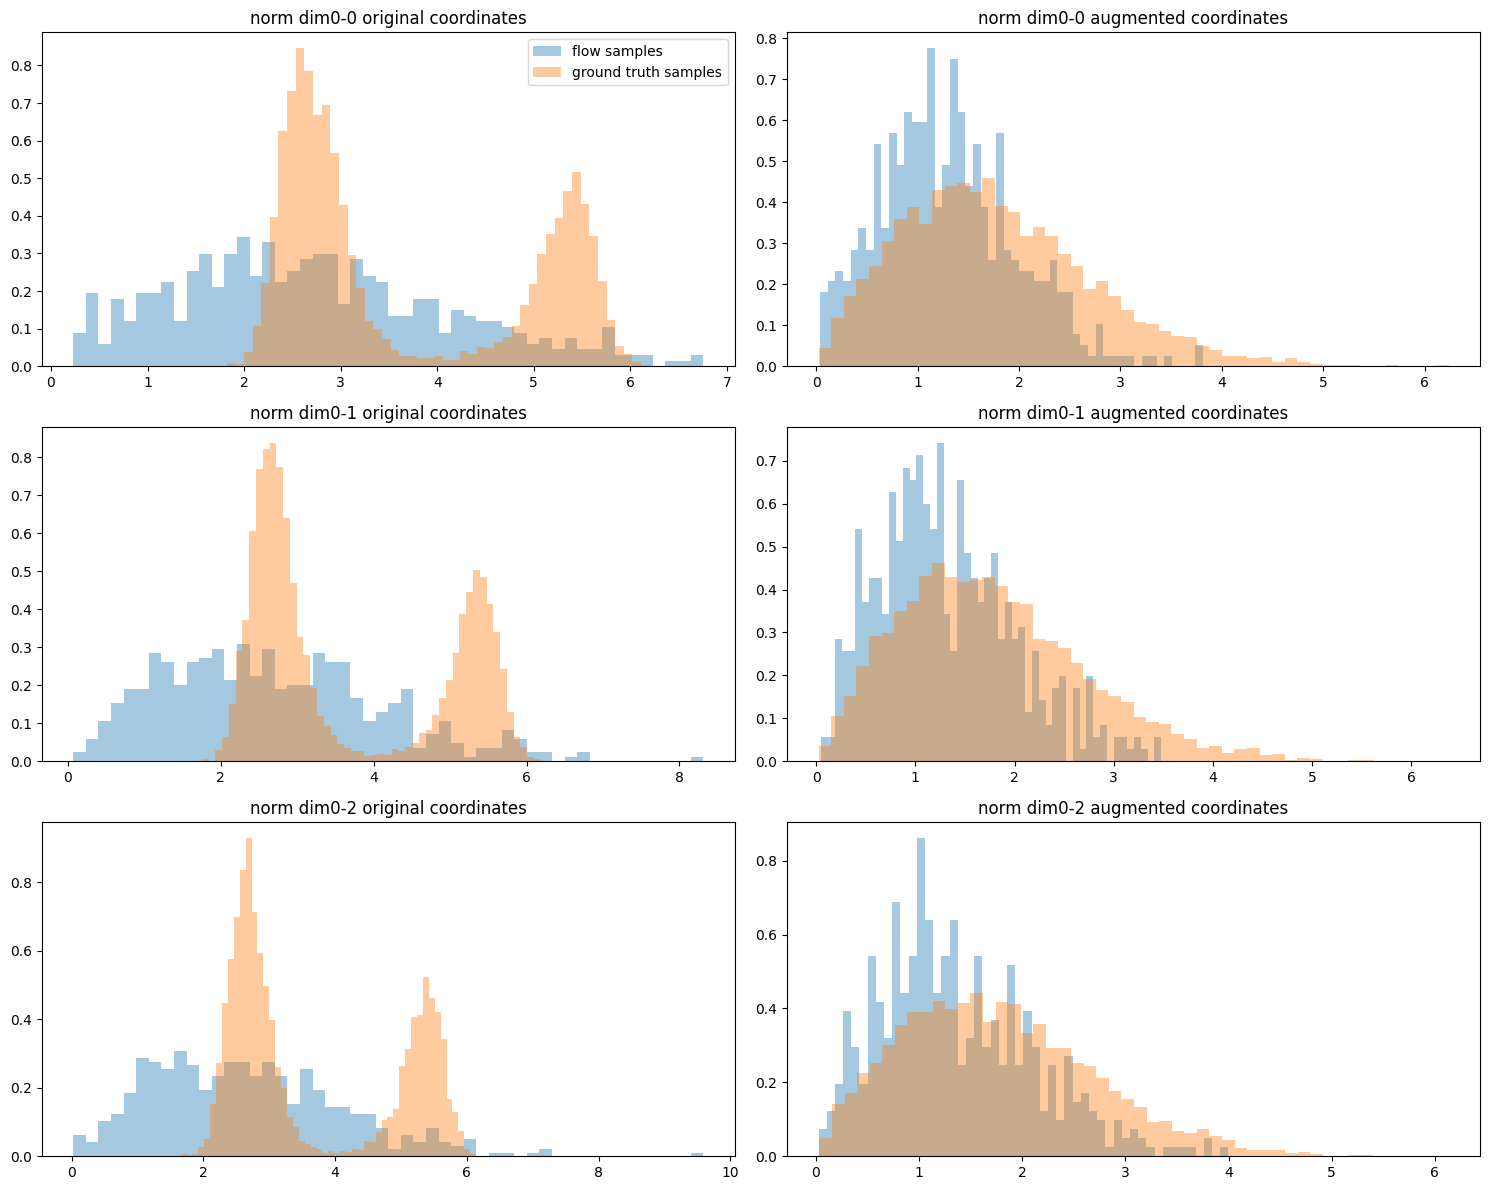

 20%|████████████████████████████████▌                                                                                                                                  | 200/1000 [01:03<03:19,  4.01it/s]

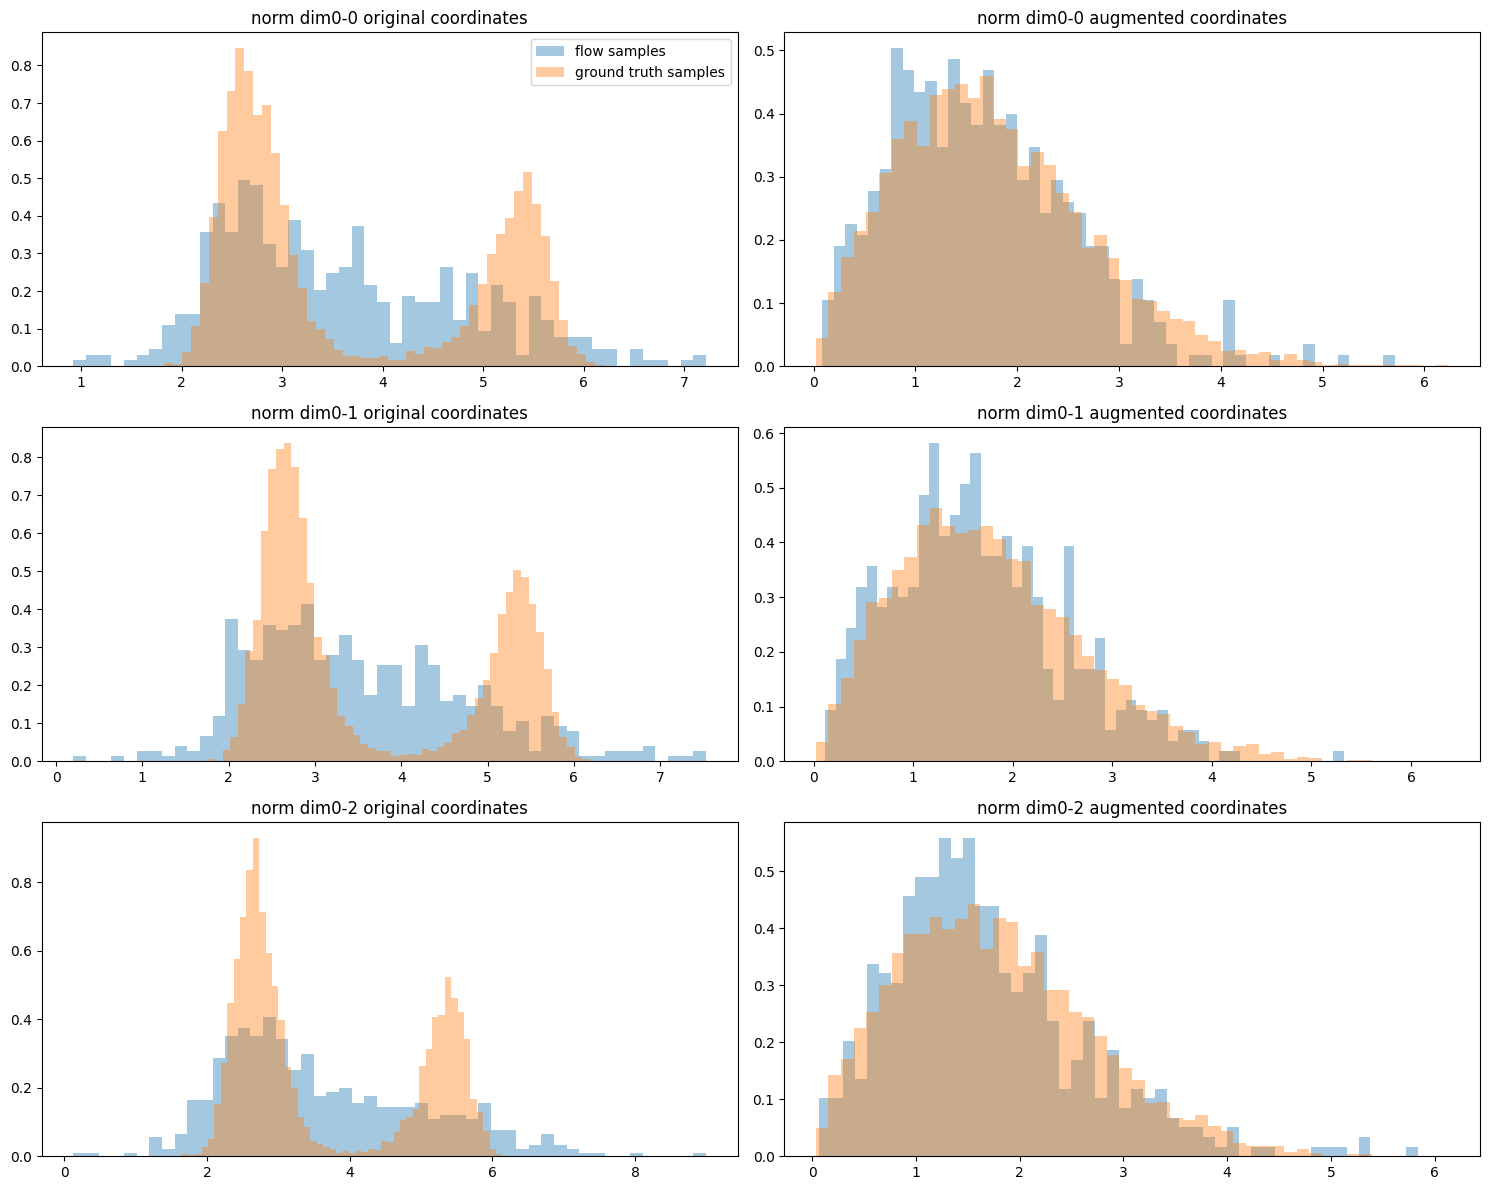

 40%|█████████████████████████████████████████████████████████████████▏                                                                                                 | 400/1000 [01:54<02:23,  4.18it/s]

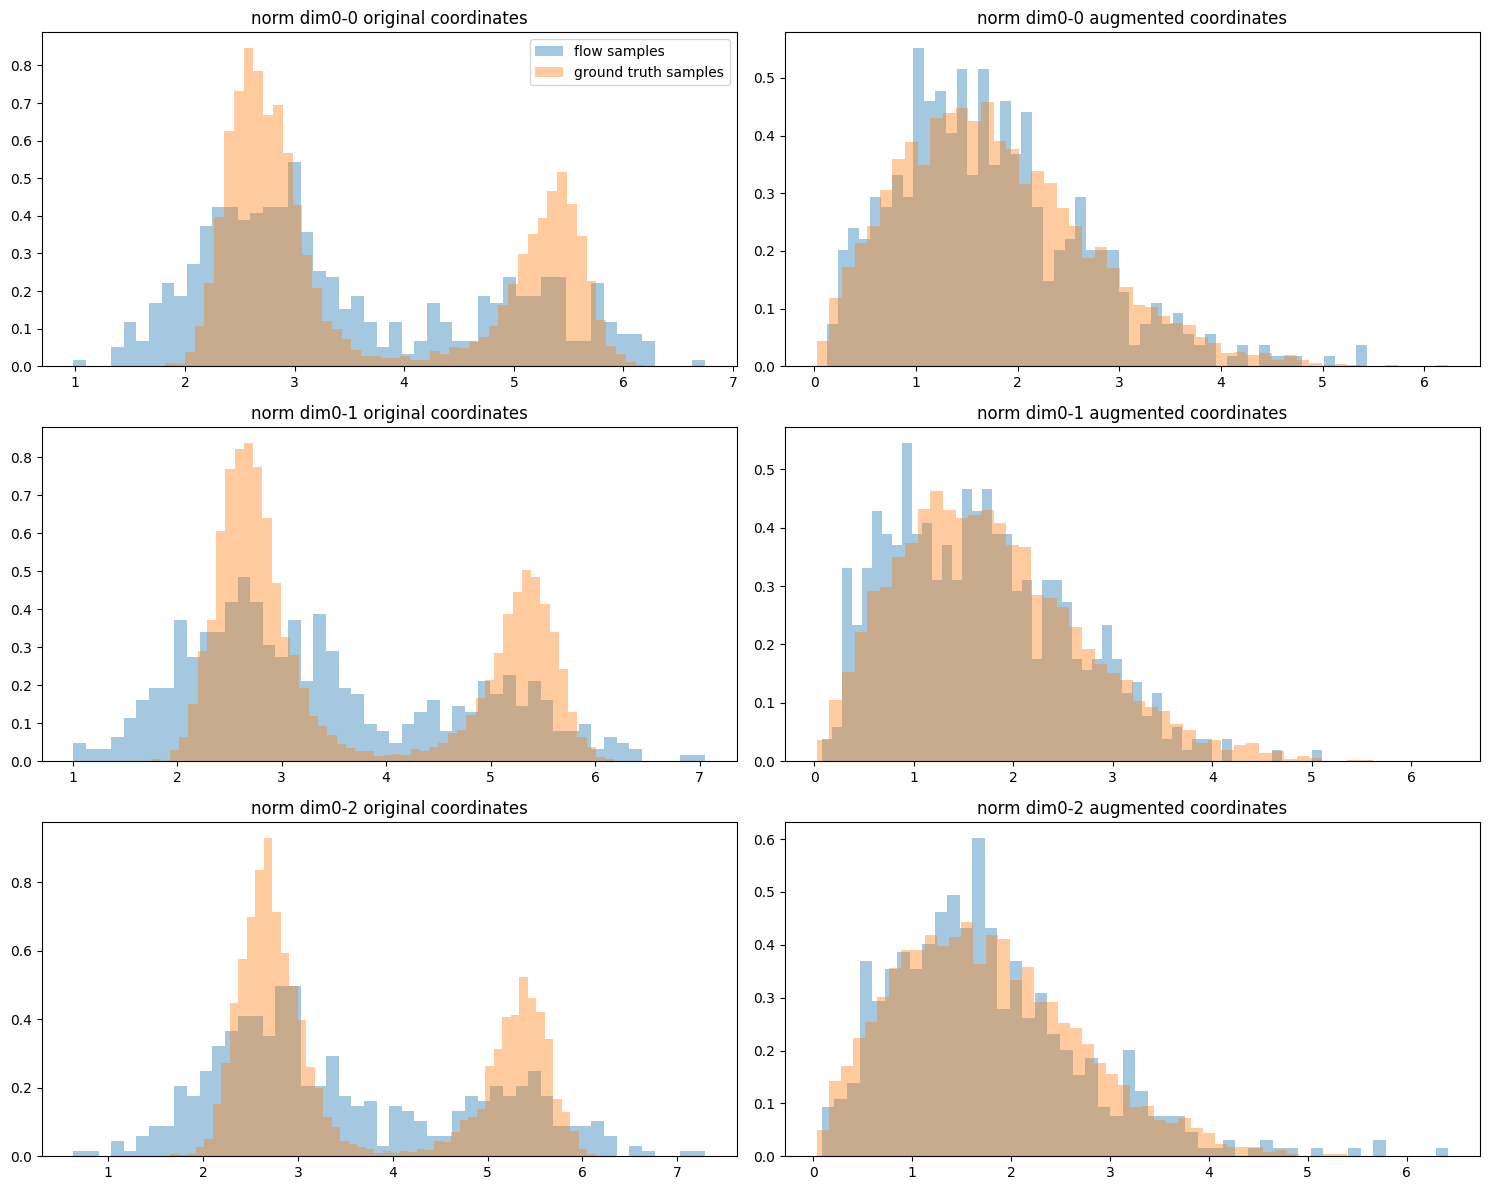

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 600/1000 [02:45<01:38,  4.06it/s]

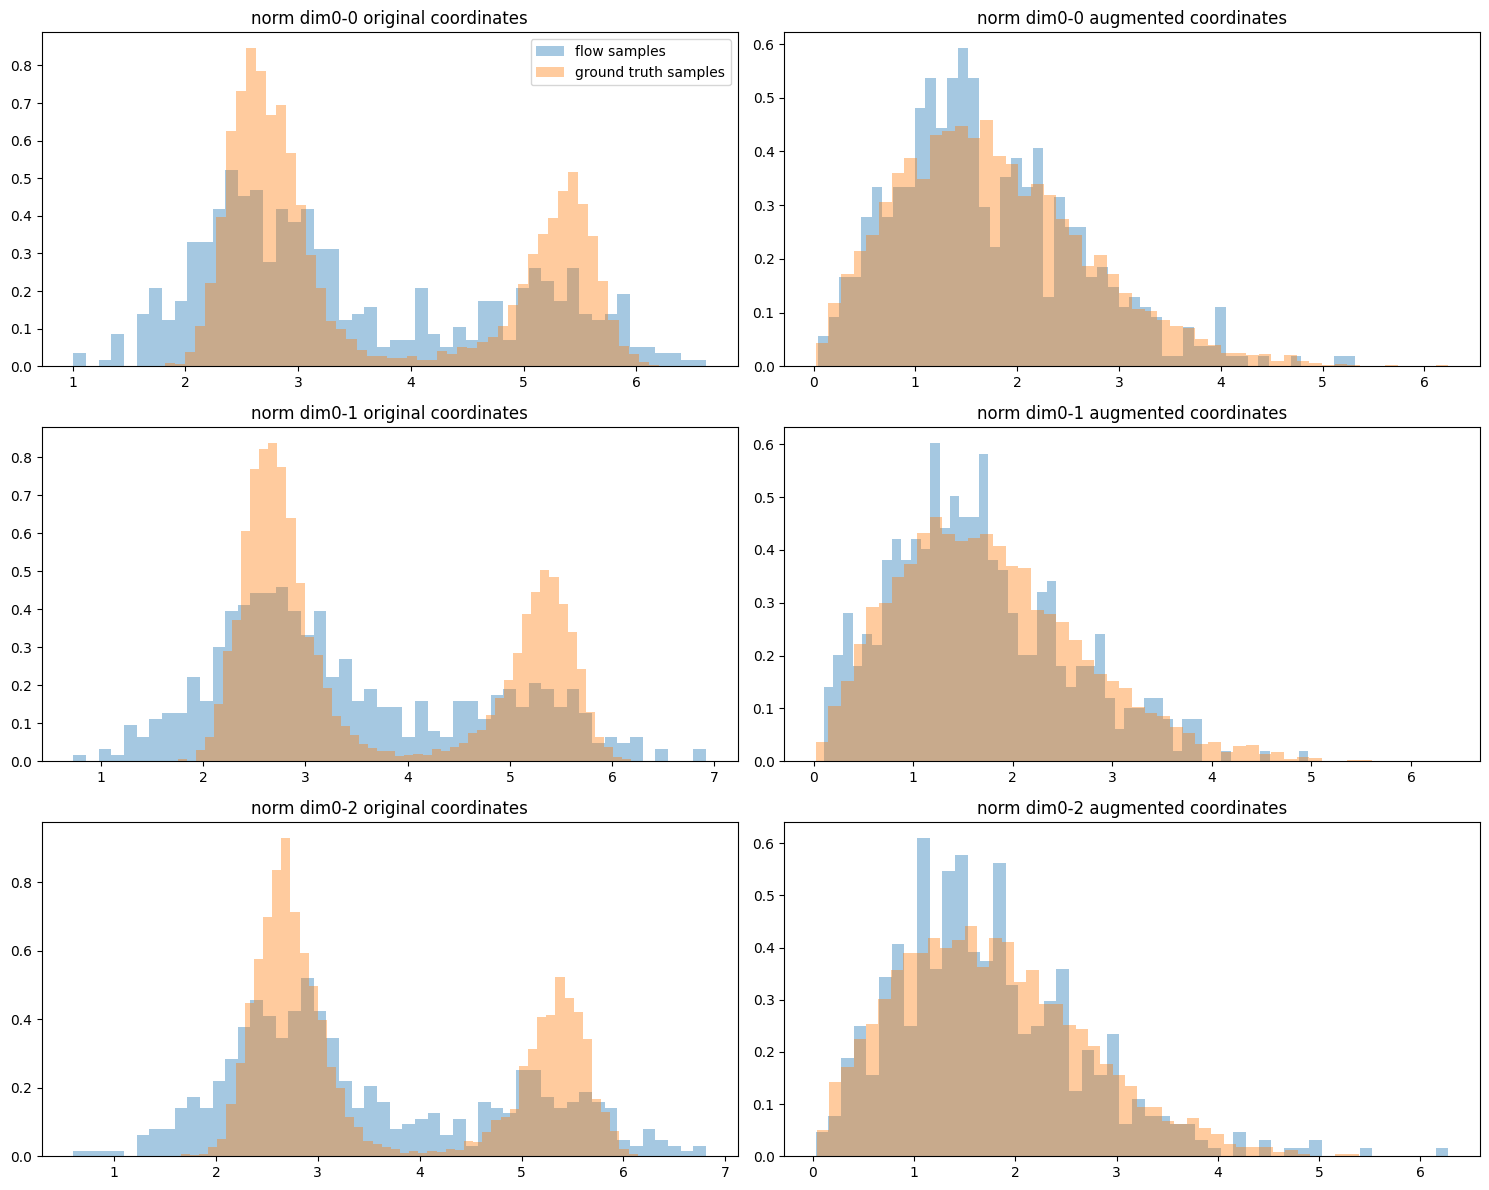

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 800/1000 [03:36<00:48,  4.15it/s]

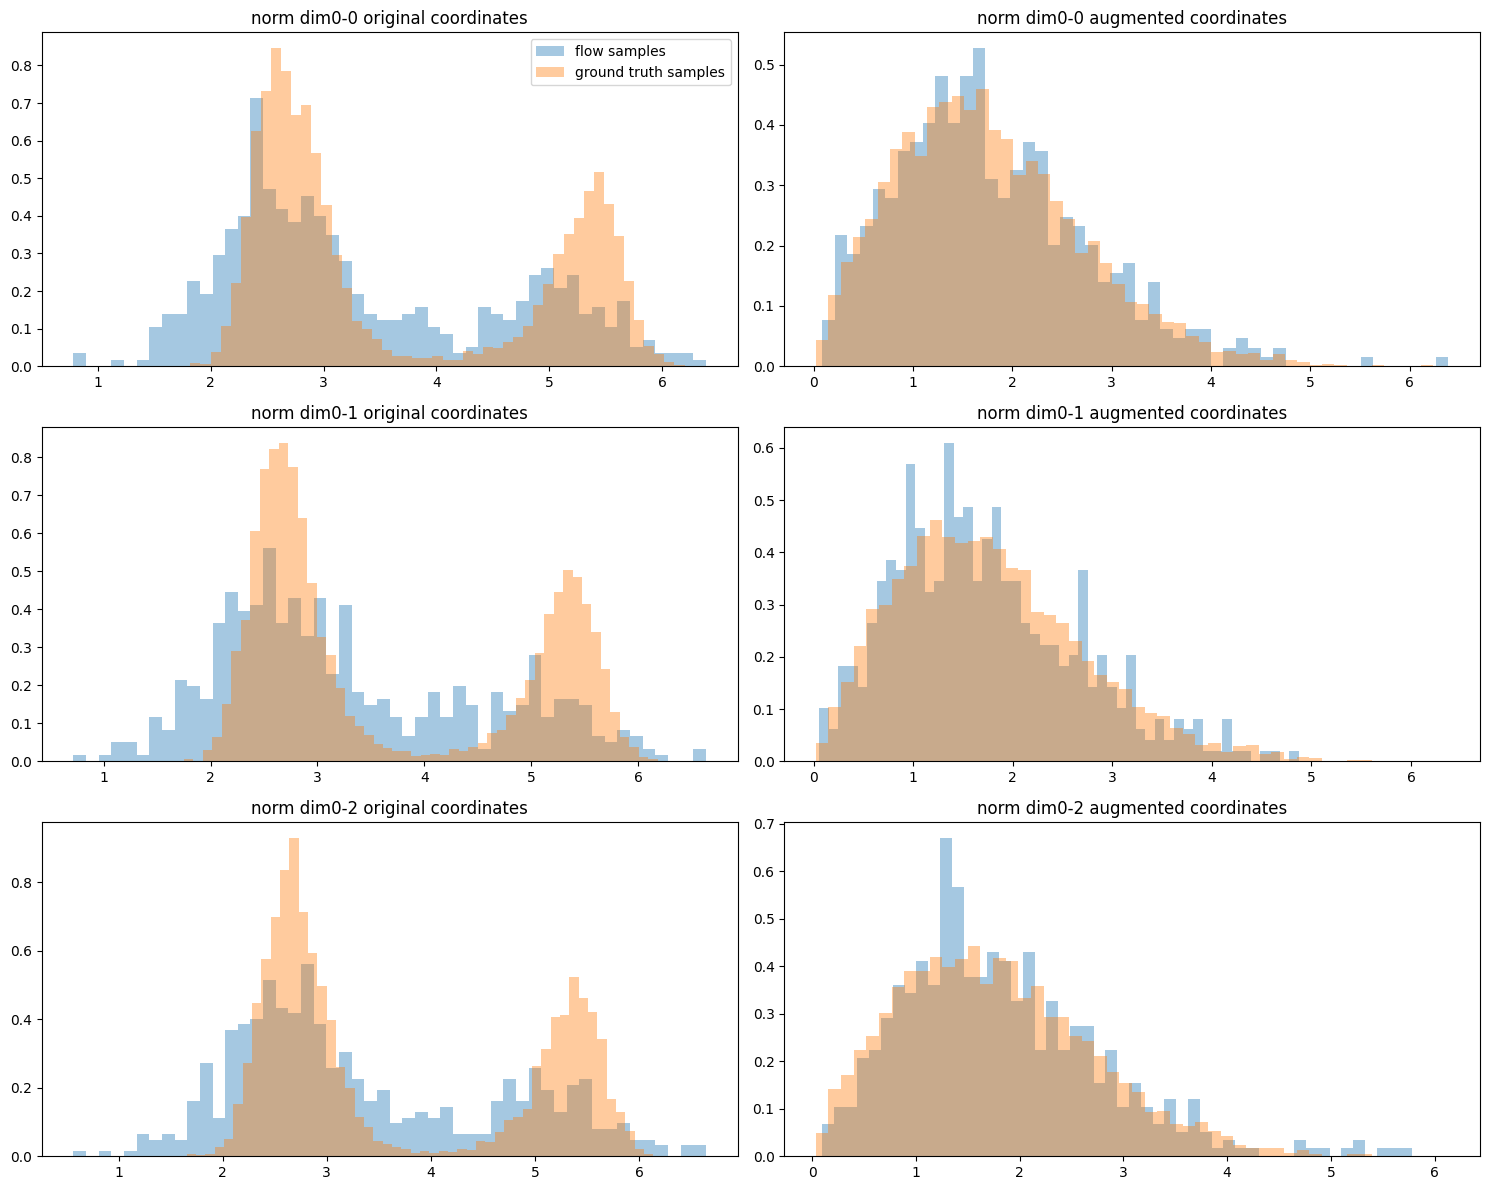

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.75it/s]


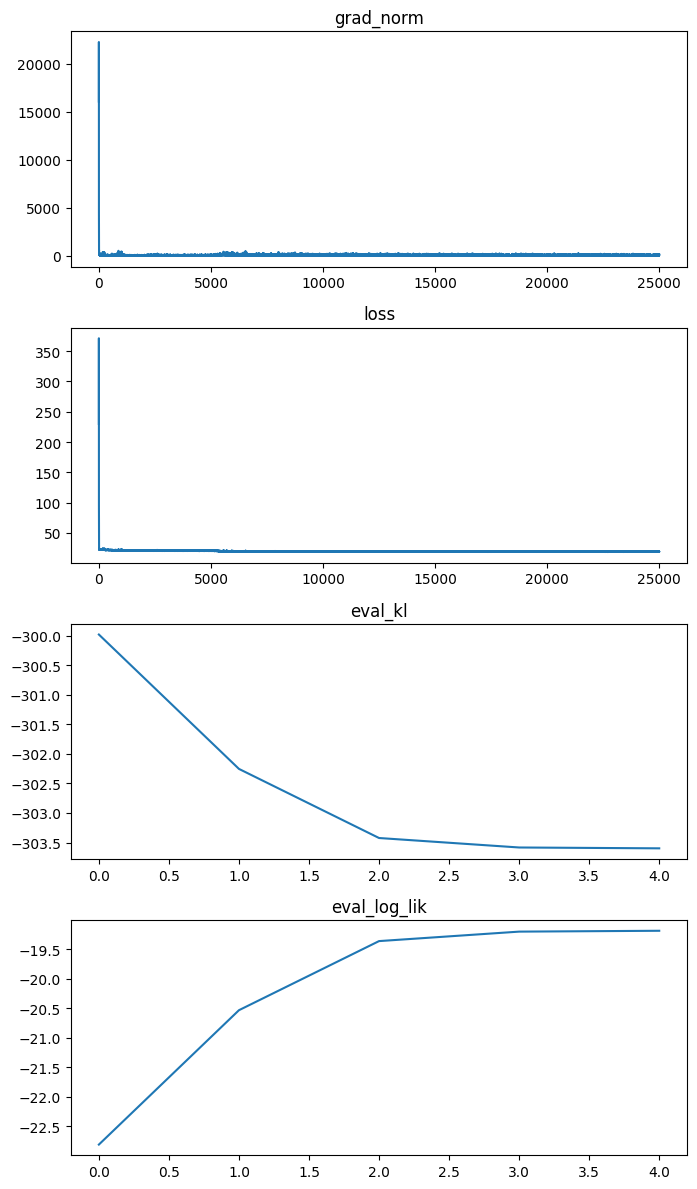

In [13]:
flow_type = "vector_scale_shift"  # "nice", "proj", "vector_scale_shift"

train_data, test_data = load_dataset(batch_size, independant=independant_target)


logger = ListLogger()


@hk.without_apply_rng
@hk.transform
def log_prob_fn(x):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.log_prob(x)

@hk.transform
def sample_and_log_prob_fn(sample_shape=()):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.sample_and_log_prob(seed=hk.next_rng_key(), sample_shape=sample_shape)

key, subkey = jax.random.split(key)
params = log_prob_fn.init(rng=subkey, x=jnp.zeros((1, n_nodes, dim*2)))

optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(max_global_norm), optax.adam(lr))
opt_state = optimizer.init(params)


plot()



pbar = tqdm(range(n_epoch))
for i in pbar:
    for x in jnp.reshape(train_data, (-1, batch_size, *train_data.shape[1:])):
        params, opt_state, info = step(params, x, opt_state, log_prob_fn, optimizer)
        logger.write(info)
        if jnp.isnan(info["grad_norm"]):
            print("nan grad")

    key, subkey = jax.random.split(key)
    train_data = jax.random.permutation(subkey, train_data, axis=0)
    if i % (n_epoch // n_plots) == 0:
        plot()
        eval_info = eval(params, test_data, log_prob_fn)
        logger.write(eval_info)


plot_history(logger.history)
plt.show()

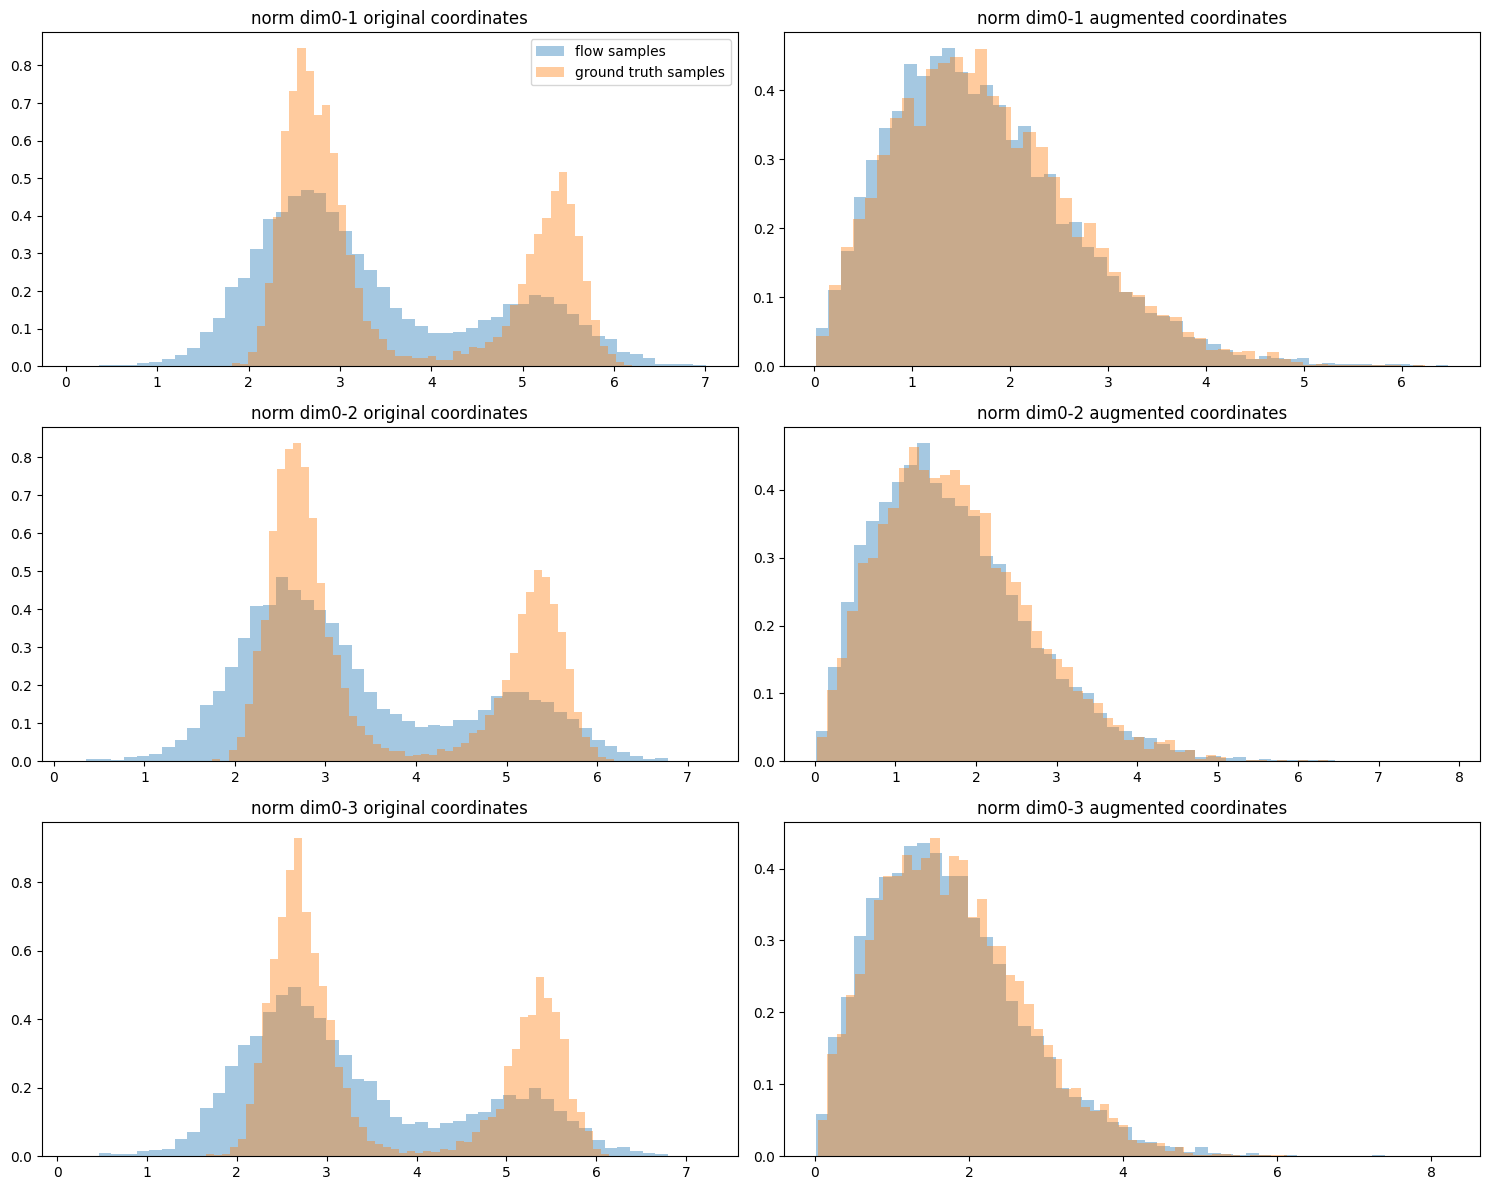

In [20]:
plot(10000)

In [15]:
# Test invariance

from flow.test_utils import test_fn_is_invariant, test_fn_is_equivariant, rotate_translate_2d

key, subkey = jax.random.split(key)
test_fn_is_invariant(lambda x: log_prob_fn.apply(params, x), subkey, n_nodes=n_nodes)

# Check that if we rotated and translate the test set, that the log prob is the same. 

key1, key2 = jax.random.split(key)
theta = jax.random.uniform(key1) * 2*jnp.pi
translation = jax.random.normal(key2, shape=(dim,))
rotated_test_data = jax.vmap(rotate_translate_2d, in_axes=(0, None, None))(test_data, theta, translation)

log_probs_test = log_prob_fn.apply(params, test_data )
log_probs_rot_test = log_prob_fn.apply(params, rotated_test_data )

# If 64 bit then very small, if 32 bit then still small but less small. 
print(jnp.sum(jnp.abs(log_probs_test - log_probs_rot_test)))

0.0046596527


In [16]:
# Check forward and inverse of the model are the same for log prob. 

sample, log_prob = sample_and_log_prob_fn.apply(params, jax.random.PRNGKey(0), (10,))

log_prob_check = log_prob_fn.apply(params, sample)

log_prob - log_prob_check

Array([ 1.9073486e-06,  0.0000000e+00,  1.9073486e-06,  1.9073486e-06,
        1.9073486e-06,  0.0000000e+00, -5.7220459e-06,  0.0000000e+00,
        1.9073486e-06,  0.0000000e+00], dtype=float32)

In [17]:
log_prob

Array([-24.154184 , -16.680197 , -15.1577015, -16.445225 , -22.424656 ,
       -20.717316 , -14.800849 , -21.219091 , -15.948683 , -16.86134  ],      dtype=float32)

In [18]:
log_prob_check

Array([-24.154186, -16.680197, -15.157703, -16.445227, -22.424658,
       -20.717316, -14.800843, -21.219091, -15.948685, -16.86134 ],      dtype=float32)